<a href="https://colab.research.google.com/github/cjohnsoncruz/neural_network_correlation_shuffle/blob/main/pytorch_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based off of work done by Frost Et al in PlosBiology, 2021: https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.3001235


In [39]:
### Import all the necessary libraries
import scipy.io
import numpy as np
import matplotlib

from matplotlib import pyplot as plt
from matplotlib import pyplot as plt

%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, transforms, utils
from torchvision.utils import save_image
from torchvision.transforms import ToTensor


from google.colab import drive
drive.mount('/content/drive')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using cpu device


In [2]:
#CREATE A FUNCTION TAHT PERFORMS SHARC, compare to swap
def do_sharc_shuffle():
      #each raster is equivalent to a collection of blocks of activity. Each block of activity is defined by the time at which it begins, its duration, and the neuron which is active.  
  activity_blocks = list()
  block_info = {'begin':[], 'duration':[], 'ID':[]}
  pass

def do_swap_shuffle():
    pass

def create_empty_corr_matrix(raster):
        #INPUT: raster (neuron x frame input)
  og_corrs = np.corrcoef(raster)
  new_corrs = np.zeros(og_corrs.shape)
  return new_corrs
    #activity blocks must contain 1) a begin time 2) a duration and 3) neuron ID
    #each dict can contain all 3 
    #SHARC is an iterative method for generating surrogate datasets.
    
    #SHARC nonrandomly shuffles blocks of activity within a raster to generate a new (surrogate) raster in which the pairwise correlations between neurons match a target correlation matrix

In [3]:
# create class for framewise activity 
class raster_dataset(Dataset):
  """ neuron dataset"""
  def __init__(self, mat_filename, transform = None):
    mat = scipy.io.loadmat(mat_filename);
    
    self.spikes = torch.from_numpy(mat['spikes']) #convert numpy array of raster to tensor 
    self.transform = transform
  def __len__(self):
    return self.spikes.shape[1]

  def __getitem__(self, index):
    sample = self.spikes[:,index]
    return sample 

  def get_slice(self, index):
    return self.spikes[:, index]

  def get_sub_slice(self, row_index, col_index):
    return self.spikes[row_index, col_index]


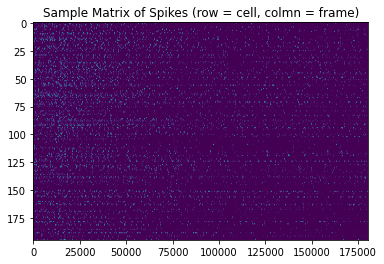

In [61]:
filename = '/content/drive/MyDrive/sampleMat.mat'
raster = raster_dataset(filename)
plt.figure();#figsize = (4,4))
plt.imshow(raster.spikes, aspect = 'auto');
plt.title('Sample Matrix of Spikes (row = cell, colmn = frame)');

In [54]:
#create class to store information on feature vector
class feature_vec(Dataset):

  def __init__(self, labels):
    self.labels = torch.from_numpy(labels) #transform label vector into tensor

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, indx):
    return self.labels[indx]


def make_rand_labels(label_len):
  rand_vec = np.random.rand(1, label_len) >= 0.5
  return rand_vec.astype(int)

class label_raster_dataset(Dataset):
  """ combined label raster dataset""" 
  def __init__(self, raster, labels):
    self.raster = raster.spikes
    self.labels = labels.labels 
  
  def __len__(self):
    return self.labels.shape[1]

  def __getitem__(self, indx):
    raster = self.raster[:,indx]
    rep = raster.shape[0] #number of times to repeat the labels to match size of raster
    label = torch.from_numpy(np.tile(self.labels[0,indx], (rep,1)))
    return raster, label #outputs tuple of tensors


In [57]:
#create random dataset for testing function of NN
rand_labels = make_rand_labels(len(raster))
rand_labels = feature_vec(rand_labels)
rand_dataset = label_raster_dataset(raster,rand_labels)

train_dataset = rand_dataset[1:100]
test_dataset = rand_dataset[200:300]

(tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8),
 tensor([[0, 0, 0,  ..., 1, 0, 1],
         [0, 0, 0,  ..., 1, 0, 1],
         [0, 0, 0,  ..., 1, 0, 1],
         ...,
         [0, 0, 0,  ..., 1, 0, 1],
         [0, 0, 0,  ..., 1, 0, 1],
         [0, 0, 0,  ..., 1, 0, 1]]))

In [58]:
BATCH_SIZE = 16 ###should never exceed size of dataset fed in for training or testing
NUM_WORKERS = 1  ### Use more workers for more CPU threads
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=BATCH_SIZE, shuffle=True)

In [60]:
#test that train loader is working 
train_sample_ras, train_sample_label = next(iter(train_loader))
train_sample_ras

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [62]:
for X, y in test_loader:
    print(f"Shape of X : {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X : torch.Size([195, 100])
Shape of y: torch.Size([195, 100]) torch.int64


In [ ]:
class TestNet(nn.Module):
  def __init__(self):
        super(TestNet, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [9]:
#build neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(28*28,1000),
                                    nn.ReLU(),
                                     nn.Linear(1000,1),
                                     
                                    
                                    )
        #create output layer

    def forward(self, x):
        x = self.encoder(x)
        logits = self.linear_relu_stack(x)

        return x
        

In [103]:
def train(train_loader, model, optimizer, criterion, n_epochs, device, log_interval): 
    model.train() # sets the parameters to be trainable
        
    for batch_idx, (data, target) in enumerate(train_loader): #target is true labels y
        
        data = data.view(-1, 28 * 28) # flatten into 1D array for dense nn
        #data.cuda()
        #target.cuda()
        device ="cuda:0"       
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        output = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
           
    print('Train Epoch: {}, Loss: {:.6f}'.format(epoch, loss.item()))  
    return loss.item()

In [ ]:
### Instantiate your model
model = Net()
device = "cuda:0"
model.to(device) # the .cuda() call puts the model onto the GPU for training



In [ ]:

### Define your loss function (training criterion)
### Choose your optimizer

optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = F.mse_loss #use functional mean square error 



In [ ]:

# gather all variables 
print("Optimizer is :", optimizer)
print("criterion is ", criterion)
print("Device is", device)
print('model is', model)
log_interval = BATCH_SIZE
print(log_interval, 'log interval')
